In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader


In [16]:
def pre_process(data, var):
    
    Q = 60.0  + np.cumsum(data.I)/36000
    data["Q"] = Q
    return data[var]

def windows (data, window_size, stride):
    
    x = np.array(data)
    length = data.shape[0]
    windows_list = []
    
    for i in range(0, length-window_size, stride):
        windows_list.append(x[i:i+window_size][np.newaxis,:])
        
    return tuple(windows_list)


class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """
    
    def __init__(self, data, window_size, stride, scale = 0, max_list=[]):
        
        x_list = []
        y_list = []
        
        for i in range(0, len(data)-window_size, stride):             
            x_list.append(data[i:i+window_size, 1:][np.newaxis,:])
            #y_list.append(data[i:i+window_size, 0][np.newaxis,:])
            y_list.append(data[i+window_size,0])
        
        self.x = np.vstack(x_list)
        self.y = np.vstack(y_list)
        
        if scale:
           
            self.max_list = max_list
            
        else:
            self.max_y = np.max(self.y)
            self.max_list = [np.max(np.max(self.x, axis=1), axis=0), self.max_y]
            
        
        self.x = np.divide(self.x, self.max_list[0])
        self.y = self.y/self.max_list[-1]
        #self.y = (self.y-np.mean(self.y))/np.std(self.y)
        
        print("x shape:", self.x.shape)
        print("y shape:", self.y.shape)
 

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.y.shape[0]

    def __add__(self, other):
        return ConcatDataset([self, other])
   
        
    
def mae(y_pred, y_true):
    loss = (torch.abs(y_pred - y_true)).mean()
    return loss    

class LSTMModel(nn.Module):
    
    def __init__(self, batch_size, seq_len, input_dim, n_layers, hidden_dim, output_dim, lin_hidden_dim = 100):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)#
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.hidden = self.init_hidden()
        self.input_dim = input_dim
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.n_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.n_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, x):
        
        #self.batch_size = len(x)
        output, (hn, cn) = self.lstm(x)
        #out1 = self.linear(output
        out1 = self.linear(hn[-1].view(len(x),-1))
        #out2 = self.linear2(F.relu(out1))
        
        #print(output.shape)
        #out = self.linear(output.view(len(x),-1))
        return out1
    
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, seq_len):
        
        super(LinearModel, self).__init__()
        self.n_features = input_dim*seq_len
        self.linear = nn.Linear(self.n_features, output_dim)
        
    def forward(self, x):
        
        out = self.linear(x.view(-1,self.n_features))
        return out
       

var = ["U", "T", "I", "Q"]
path = "C:/Users/Sebastian/Documents/Data Analytics Master/Semester4-Thesis/Datasets/Battery-data/vw/DataLake/DataLake/0/EH_AgingStatus_0Y_Temp_11_rndLC_W.csv"

In [17]:
data = pd.read_csv(path)
data = pre_process(data, var)
data.head()

,U,T,I,Q
0,4.250048,11.0,0.0,60.0
1,4.250048,11.0,0.0,60.0
2,4.250048,11.0,0.0,60.0
3,4.250048,11.0,0.0,60.0
4,4.250048,11.0,0.0,60.0


In [18]:
stride = 10
window_size = 50
backcast = window_size
forecast = 1
train_split = int(len(data)*0.6)
val_split = int(len(data)*0.8)
batch_size = 1024
seq_len = backcast
output_dim = forecast
input_dim = 3
n_layers = 1
hidden_dim = 50


In [19]:
data = np.array(data)

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

idx = np.arange(len(data))

#dont apply it for time series
#np.random.shuffle(idx)

train_idx = idx[:train_split]
val_idx = idx[train_split:val_split]
test_idx = idx[val_split:]

train_dataset = Dataset(data[train_idx], window_size, stride)
train_loader = DataLoader(train_dataset, **params)
train_iter = iter(train_loader)

test_dataset = Dataset(data[test_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list)
test_loader = DataLoader(test_dataset, **params)
test_iter = iter(test_loader)

val_dataset = Dataset(data[val_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list)
val_loader = DataLoader(val_dataset, **params)
val_iter = iter(val_loader)


x shape: (5819, 50, 3)
y shape: (5819, 1)
x shape: (1937, 50, 3)
y shape: (1937, 1)
x shape: (1937, 50, 3)
y shape: (1937, 1)


In [25]:

model = LSTMModel (batch_size, seq_len, input_dim, n_layers, hidden_dim, output_dim)
#model = LinearModel(input_dim, output_dim, seq_len)
optimizer = optim.Adam(model.parameters(), lr=0.001)
max_epochs = 100
val_loss_list = []
prev_loss = np.inf
for i in range(max_epochs):
    
    train_iter = iter(train_loader)
    train_loss = 0.0
    for x_train, y_train in train_iter:
    
        model.zero_grad()
        x_train, y_train = torch.tensor(x_train).float(), torch.tensor(y_train).float()

        #model.batch_size = x_train.shape[0]
        #hidden_init = model.init_hidden()
        y_pred = model(x_train)
        loss = mae(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.numpy()*x_train.shape[0]
    print("Train loss:", train_loss/len(train_dataset))
        
        
    val_loss = 0.0
    for x_val, y_val in val_loader:
        x_val, y_val = torch.tensor(x_val).float(), torch.tensor(y_val).float()
        #if(x_val.shape[0]==batch_size):
        model.batch_size = x_val.shape[0]
        hidden_init = model.init_hidden()
        y_pred = model(x_val)
        val_loss += mae(y_pred, y_val).data.numpy()*x_val.shape[0]
    val_loss /= (len(val_dataset)*forecast)
    
    #if(val_loss>prev_loss):
    #    break
        
    prev_loss = val_loss
    val_loss_list.append(val_loss)
    print(val_loss)

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Train loss: 0.8981012045609867


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.7673860919432475
Train loss: 0.7859918006016721
0.6643968719025525
Train loss: 0.6577146703853991
0.5276548080242474
Train loss: 0.46100221528980734
0.2738541657923421
Train loss: 0.15068988225205612
0.1452232509328338
Train loss: 0.11037804718921737
0.09914676121940426
Train loss: 0.0854421067188431
0.056737304624279686
Train loss: 0.0468155585279332
0.035129795776979174
Train loss: 0.03569269393290476
0.05769895953181545
Train loss: 0.029903982177794153
0.0218771833101375
Train loss: 0.022699420583152878
0.04198842875517147
Train loss: 0.01568875377039065
0.03159945047949477
Train loss: 0.011386521604897374
0.029296022422023206
Train loss: 0.010559687970619387
0.028984411889336193
Train loss: 0.009930198318189741
0.031810811278927126
Train loss: 0.009024295850104279
0.03311652416689345
Train loss: 0.008678634753596395
0.03452575668138699
Train loss: 0.008447216268008487
0.03587361711914477
Train loss: 0.008353132059473386
0.0405020072852359
Train loss: 0.008268068289129129
0.044134

KeyboardInterrupt: 

In [26]:
samples = 1000
model.batch_size = samples
y_pred = model(torch.tensor(train_dataset.x[:samples]).float())

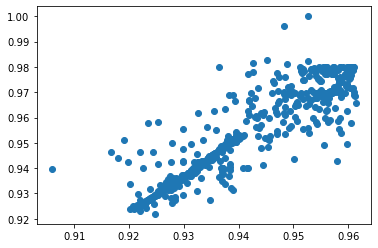

In [27]:
plt.scatter(y_pred.detach().numpy(), train_dataset.y[:samples])

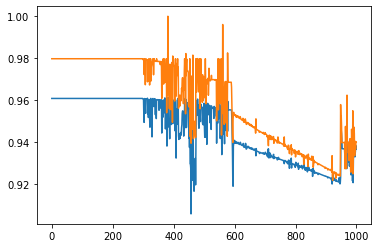

In [28]:
plt.plot(y_pred.detach().numpy())
plt.plot( train_dataset.y[:samples])

In [29]:
samples = 1000
model.batch_size = samples
y_pred = model(torch.tensor(test_dataset.x[:samples]).float())

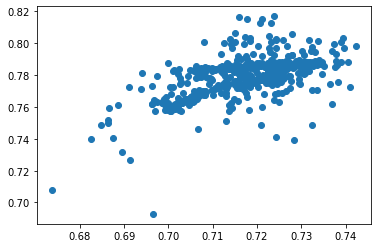

In [30]:
plt.scatter(y_pred.detach().numpy(), test_dataset.y[:samples])

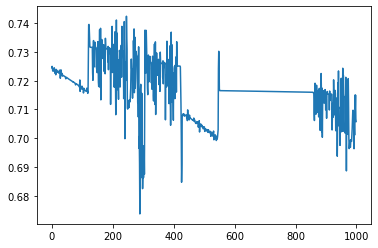

In [31]:
plt.plot(y_pred.detach().numpy())


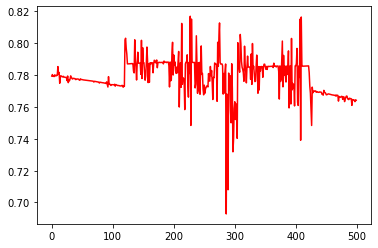

In [32]:
plt.plot( test_dataset.y[:samples-500], "r")

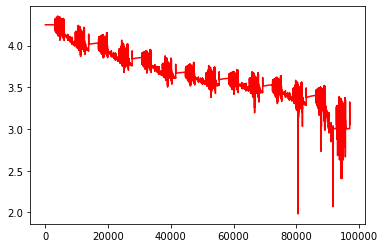

In [33]:
plt.plot(data[:100000, 0], "r")

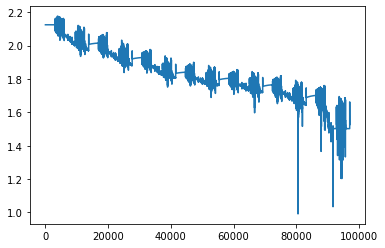

In [34]:
plt.plot(0.5*data[:, 0])


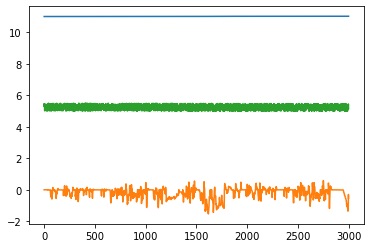

In [49]:
plt.plot(data[3000:6000, 1])
plt.plot(data[3000:6000, 2]*0.01)
plt.plot(data[3000:6000, 3]/60+4+0.5*np.random.random(3000))

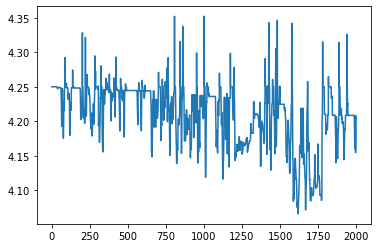

In [50]:
plt.plot(data[3000:5000, 0])
